In [1]:
# import required modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from infrasim.component import Component
import pandas as pd
import numpy as np

In [2]:
# load component data
gen_admin_params = pd.read_csv('selected_15_components_data.csv')

component_ids = list(gen_admin_params['component_id'])
dynamics_shapes = list(gen_admin_params['shape'])
dynamics_scales = list(gen_admin_params['scale'])
inspection_costs = list(gen_admin_params['inspection_cost'])
replacement_costs = list(gen_admin_params['replacement_cost'])

In [47]:
def run_simulations(component, budget, num_trials, inspect_interval, replace_failure_threshold, visualize=False):

    # run a policy on the component with baseline strategy
    inspect_interval = inspect_interval
    replace_failure_threshold = replace_failure_threshold
    t2f_ratio = []

    for trial in range(num_trials):
        budget_remaining = budget
        component.reset()
        num_steps = 0
        estimated_state = 100
        num_survive_steps = 0

        while budget_remaining > 0 and num_steps < 100 and component.current_state > 0:

            if component.current_state > 0:
                num_survive_steps += 1

            # inspection step
            if num_steps % inspect_interval == 0:
                component.update(action=1)
                budget_remaining -= component.inspect_cost
                estimated_state = component.current_state
            else:
                # update estimated state to next state with highest probability
                estimated_state = np.argmax(component.trans_prob[component.current_state,0,:])  
                # replacement
                if estimated_state < 10: #component.get_failure_probability(estimated_state) >= replace_failure_threshold and budget_remaining >= component.replace_cost:
                    component.update(action=2)
                    budget_remaining -= component.replace_cost
                    estimated_state = component.current_state
                else:
                    component.update(action=0)

            num_steps += 1
        
            if visualize == True:
                component.visualize_history()
                print(f"Remaining budget: {budget_remaining}")
            t2f_ratio.append(num_survive_steps/100.0)

    return np.mean(t2f_ratio), np.std(t2f_ratio)

In [48]:
# run simulations with components

t2f_means = np.zeros((len(component_ids),51))
t2f_stds = np.zeros((len(component_ids),51))
budgets = np.arange(0,1001,20)
inspect_interval = 3
num_trials = 5
replace_failure_threshold = 0.2

for i in range(len(component_ids)):

    component =  Component(name=f'{component_ids[i]}', inspect_cost=inspection_costs[i], replace_cost=replacement_costs[i], dynamics_scale=dynamics_scales[i], dynamics_shape=dynamics_shapes[i])

    # load dynamics npy file
    trans_prob_maintain = np.load(f'./dynamics/dynamics_{component_ids[i]}.npy')
    component.trans_prob[:,0,:] = trans_prob_maintain[:,0,:]
    component.trans_prob[:,1,:] = trans_prob_maintain[:,0,:]
    
    for j in range(len(budgets)):
        
        probs_mean, probs_std =  run_simulations(component, budgets[j], num_trials=num_trials, inspect_interval=inspect_interval, replace_failure_threshold=replace_failure_threshold)
        t2f_means[i,j] = probs_mean
        t2f_stds[i,j] = probs_std


c:\Users\pranayt2\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pranayt2\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\pranayt2\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\pranayt2\Anaconda3\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
c:\Users\pranayt2\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [49]:
np.save('./results/baseline_t2f_means.npy',t2f_means)
np.save('./results/baseline_t2f_stds.npy', t2f_stds)

79
75
48
15
5
Replaced due to failure probability 0.12948962135512565
79
54
51
8
Replaced due to failure probability 0.07385839322135238
79
50
22
12
9
Replaced due to failure probability 0.06306671148243634
75
63
40
17
16
4
Replaced due to failure probability 0.1635678608801238
79
70
44
42
5
Replaced due to failure probability 0.12948962135512565
79
79
76
69
54
22
19
3
Replaced due to failure probability 0.21513997449679875
79
50
50
17
12
57
57


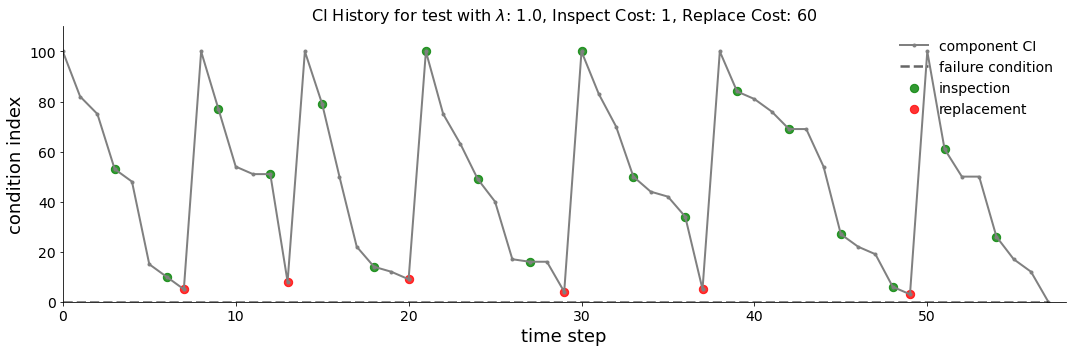

In [46]:
# testing for a single component and budget

# run a policy on the component with baseline strategy
inspect_interval = 3
replace_failure_threshold = 0.2
survive_probs = []

budget_remaining = 1000.0
num_steps = 0
estimated_state = 100
num_survive_steps = 0

i = 14
component =  Component(name='test', inspect_cost=1, replace_cost=60, dynamics_scale=36.6, dynamics_shape=1.68)
trans_prob_maintain = np.load(f'./dynamics/dynamics_{component_ids[i]}.npy')
component.trans_prob[:,0,:] = trans_prob_maintain[:,0,:]
component.trans_prob[:,1,:] = trans_prob_maintain[:,0,:]
component.reset()

while budget_remaining > 0 and num_steps < 100 and component.current_state > 0:

    if component.current_state > 0:
        num_survive_steps += 1

    # inspection step
    if num_steps % inspect_interval == 0:
        component.update(action=1)
        budget_remaining -= component.inspect_cost
        estimated_state = component.current_state
    else:
        # update estimated state to next state with highest probability
        estimated_state = np.argmax(component.trans_prob[component.current_state,0,:])  
        print(estimated_state)
        # replacement
        if estimated_state < 10:# component.get_failure_probability(estimated_state) >= replace_failure_threshold and budget_remaining >= component.replace_cost:
            component.update(action=2)
            print(f'Replaced due to failure probability {component.get_failure_probability(estimated_state)}')
            budget_remaining -= component.replace_cost
            estimated_state = component.current_state
        else:
            component.update(action=0)

    num_steps += 1

print(num_steps)
print(num_survive_steps)
component.visualize_history()

## Baseline Budget Allocation

# baseline budget allocation to components based on MTTF and replacement costs


# load component data
gen_admin_params = pd.read_csv('selected_15_components_data.csv')
component_ids = list(gen_admin_params['component_id'])
dynamics_shapes = list(gen_admin_params['shape'])
dynamics_scales = list(gen_admin_params['scale'])
inspection_costs = list(gen_admin_params['inspection_cost'])
replacement_costs = list(gen_admin_params['replacement_cost'])


# create components and calculate MTTF
mttf_data = []